## Causal S-Learner Classifier

### TL; DR
---
This notebooks exemplifies how one can use the causal S-learner through fklearn.

### Long
---
A very interesting and useful type of causal models are uplift models, in which one is able to identify how each sample responds to a given treatment, and what is the effect of that treatment compared to a control group. The main goal of uplift models is, therefore, to learn the difference in probability of a sample converting (using a product), given that it was submitted to some action (nudge). Meta-learns are examples of causal models, in which the CATE represents how each unit will respond to a given treatment [1]. In fact, the uplift can be understood as the incremental gain in the conversion probability in the case a given sample was in the treatment group instead of the control one. In addition, these models have the advantage of using conventional machine learning models, such as LightGBM.

More specifically, the S-learner is a meta-learner which learns the Conditional Average Treatment Effect (CATE) through the creation of an auxiliary binary feature $T$ that indicates if the samples is in the treatment ($T = 1$) or in the control ($T = 0$) group. Then, this feature can then be used to perform inference by artificially simulating the conversion of a new sample $i$ in both scenarios, i.e., with $T = 0$ and $T = 1$. The CATE $\tau$ is defined as $\tau(x_{i}) = M(X=x_{i}, T=1) - M(X=x_{i}, T=0)$, being $M$ a Machine Learning Model such as a LightGBM Classifier and $x_{i}$ the feature set of sample $i$.

### Data
---
The data here adopted is provided in [1], [2].

### References
---

[1] https://matheusfacure.github.io/python-causality-handbook/21-Meta-Learners.html

[2] https://github.com/matheusfacure/python-causality-handbook/tree/master/causal-inference-for-the-brave-and-true/data

[3] https://causalml.readthedocs.io/en/latest/methodology.html

In [2]:
RANDOM_SEED = 42

### 1. Imports

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from fklearn.causal.cate_learning.meta_learners import causal_s_classification_learner
from fklearn.training.classification import lgbm_classification_learner
from fklearn.training.calibration import isotonic_calibration_learner
from fklearn.causal.validation.curves import cumulative_gain_curve
from fklearn.training.pipeline import build_pipeline
from fklearn.training.transformation import ecdfer

sns.set_style("darkgrid")

### 2. Functions

In [4]:
def plot_cumulative_gain_curve(
    train_gain: np.ndarray,
    test_gain: np.ndarray,
    random_gain: np.ndarray,
    fontsize: int = 16,
    figsize: tuple = (15,5)
) -> None:
    """
    Plots the cumulative gain curve.
    """

    xaxis = np.arange(len(train_gain))/len(train_gain)
    
    plt.figure(figsize=figsize);
    plt.plot(xaxis, train_gain, label="Training Data");
    plt.plot(xaxis, test_gain, label="Testing Data");
    plt.plot(xaxis, random_gain, "--", label="Random");
               
    plt.ylabel("Cumulative Gain", fontsize=fontsize);
    plt.xlabel("Population Proportion", fontsize=fontsize);
    plt.title("Cumulative Gain Curve", fontsize=fontsize);
               
    plt.legend(fontsize=fontsize);
    plt.xticks(fontsize=fontsize);
    plt.yticks(fontsize=fontsize);

### 3. Read Data

Notice that the data here adopted is provided in [1] and [2].

In [5]:
test_data = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/invest_email_rnd.csv"
)
train_data = pd.read_csv(
    "https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/invest_email_biased.csv"
)

In [6]:
test_data.shape

(15000, 8)

In [7]:
train_data.shape

(15000, 8)

#### 3.1 Include Treatment Column

In [8]:
train_data["control"] = np.where((train_data["em1"]+train_data["em2"]+train_data["em3"])==0,1,0)
train_data["treatment_col"] = train_data[["em1","em2","em3","control"]].idxmax(axis=1).values

test_data["control"] = np.where((test_data["em1"]+test_data["em2"]+test_data["em3"])==0,1,0)
test_data["treatment_col"] = test_data[["em1","em2","em3","control"]].idxmax(axis=1).values

In [9]:
train_data.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1


In [10]:
test_data.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,0,em2
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,0,em1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,0,em1
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,0,em1


### 4. Causal S-Learner

In [11]:
target_column = "converted"
features = ["age", "income", "insurance", "invested"]
treatment_column = "treatment_col"
control_name = "control"
prediction_column = "prediction"

#### 4.1 Using S-Learner with LightGBM

In [12]:
clf_learner = lgbm_classification_learner(
    features = features,
    target = target_column,
    prediction_column = prediction_column,
    extra_params={"random_state": RANDOM_SEED}
)

In [13]:
s_learner = causal_s_classification_learner(
    treatment_col=treatment_column,
    control_name=control_name,
    prediction_column=prediction_column,
    learner=clf_learner
)

**Training the model**

In [14]:
s_learner_fcn, s_learner_train_df, s_learner_log = s_learner(train_data)

[LightGBM] [Info] Number of positive: 1896, number of negative: 8896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 10792, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175686 -> initscore=-1.545855
[LightGBM] [Info] Start training from score -1.545855
[LightGBM] [Info] Number of positive: 1306, number of negative: 6376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170008 -> initscore=-1.585572
[Ligh

In [15]:
s_learner_fcn

<function fklearn.causal.cate_learning.meta_learners.causal_s_classification_learner.<locals>.p(new_df: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame>

In [16]:
s_learner_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,...,treatment_em3__prediction_on_control,treatment_em3__uplift,treatment_em1__prediction_on_treatment,treatment_em1__prediction_on_control,treatment_em1__uplift,treatment_em2__prediction_on_treatment,treatment_em2__prediction_on_control,treatment_em2__uplift,uplift,suggested_treatment
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3,...,0.145432,0.079508,0.389475,0.188302,0.201173,0.311698,0.214005,0.097694,0.201173,treatment_em1
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,...,0.096589,0.041574,0.110037,0.091109,0.018928,0.107720,0.117808,-0.010088,0.041574,treatment_em3
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3,...,0.252133,0.098409,0.643443,0.206192,0.437251,0.127880,0.037893,0.089987,0.437251,treatment_em1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control,...,0.102683,0.044818,0.163416,0.086991,0.076425,0.121535,0.074040,0.047495,0.076425,treatment_em1
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1,...,0.014626,0.014597,0.138120,0.029866,0.108254,0.033475,0.010102,0.023372,0.108254,treatment_em1


Notice that a score for each treatment is provided considering both the machine learning models (m1 and m2) and the uplift causal model. Moreover, a suggested treatment is also provided, which is the one with the highest uplift. The uplift variable, in turn, provides the uplift of the best treatment. In the next sections, lets explore the predictions considering the em1 treatment only, following the example in [1].

In [17]:
score_of_interest = "treatment_em1__uplift"

**Making Predictions**

In [18]:
s_learner_test_df = s_learner_fcn(test_data)

In [19]:
s_learner_test_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,...,treatment_em3__prediction_on_control,treatment_em3__uplift,treatment_em1__prediction_on_treatment,treatment_em1__prediction_on_control,treatment_em1__uplift,treatment_em2__prediction_on_treatment,treatment_em2__prediction_on_control,treatment_em2__uplift,uplift,suggested_treatment
0,44.1,5483.80,6155.29,14294.81,0,1,1,0,0,em2,...,0.145432,0.079508,0.389475,0.188302,0.201173,0.311698,0.214005,0.097694,0.201173,treatment_em1
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,...,0.096589,0.041574,0.110037,0.091109,0.018928,0.107720,0.117808,-0.010088,0.041574,treatment_em3
2,49.0,2712.51,5707.08,5095.65,1,0,1,1,0,em1,...,0.252133,0.098409,0.643443,0.206192,0.437251,0.127880,0.037893,0.089987,0.437251,treatment_em1
3,39.7,2326.37,15657.97,6345.20,1,1,1,0,0,em1,...,0.102683,0.044818,0.163416,0.086991,0.076425,0.121535,0.074040,0.047495,0.076425,treatment_em1
4,35.3,2787.26,27074.44,14114.86,1,1,1,0,0,em1,...,0.014626,0.014597,0.138120,0.029866,0.108254,0.033475,0.010102,0.023372,0.108254,treatment_em1


**Create Random Score**

Let's also create a random score that can be used to compute the Cumulative Gain curve.

In [20]:
random_score_df = test_data[["em1", target_column]].copy()
random_score_df[score_of_interest] = np.random.uniform(0,1,random_score_df.shape[0])

**Checking Cumulative Gain Curve**

For more details about causal models evaluation, please look at the following reference:

https://matheusfacure.github.io/python-causality-handbook/19-Evaluating-Causal-Models.html?highlight=gain%20curve    

In [21]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = score_of_interest
)

In [22]:
gain_curve_train = gain_curve(s_learner_train_df)
gain_curve_test = gain_curve(s_learner_test_df)
gain_curve_random = gain_curve(random_score_df)

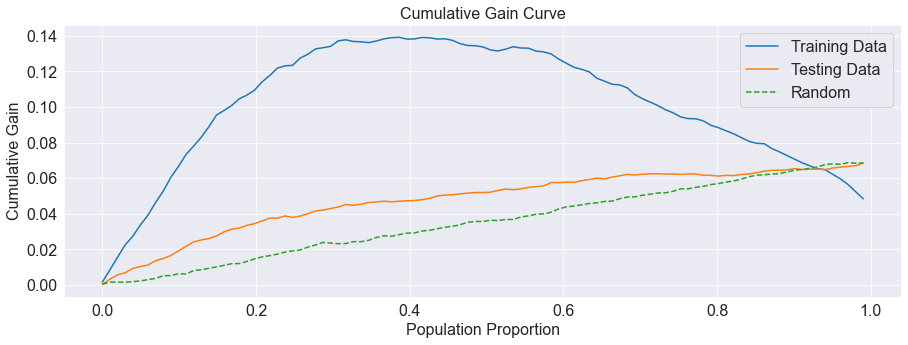

In [23]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)

#### 4.2 Using S-Learner with Fklearn Pipeline

As an example, lets build a CDF on top of the EM1 uplift score.

In [24]:
cdf = ecdfer(
    prediction_column=score_of_interest
)

In [25]:
pipeline = build_pipeline(
    *[s_learner, cdf]
)

In [26]:
pipe_fcn, pipe_train_df, pipe_log = pipeline(
    train_data
)

[LightGBM] [Info] Number of positive: 1896, number of negative: 8896
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 10792, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175686 -> initscore=-1.545855
[LightGBM] [Info] Start training from score -1.545855
[LightGBM] [Info] Number of positive: 1306, number of negative: 6376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170008 -> initscore=-1.585572
[LightGBM] [Info] Start training from score -1.585572
[LightGBM] [Inf

In [27]:
pipe_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,...,treatment_em3__uplift,treatment_em1__prediction_on_treatment,treatment_em1__prediction_on_control,treatment_em1__uplift,treatment_em2__prediction_on_treatment,treatment_em2__prediction_on_control,treatment_em2__uplift,uplift,suggested_treatment,prediction_ecdf
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3,...,0.079508,0.389475,0.188302,0.201173,0.311698,0.214005,0.097694,0.201173,treatment_em1,774.866667
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,...,0.041574,0.110037,0.091109,0.018928,0.107720,0.117808,-0.010088,0.041574,treatment_em3,71.466667
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3,...,0.098409,0.643443,0.206192,0.437251,0.127880,0.037893,0.089987,0.437251,treatment_em1,989.200000
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control,...,0.044818,0.163416,0.086991,0.076425,0.121535,0.074040,0.047495,0.076425,treatment_em1,273.866667
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1,...,0.014597,0.138120,0.029866,0.108254,0.033475,0.010102,0.023372,0.108254,treatment_em1,413.133333


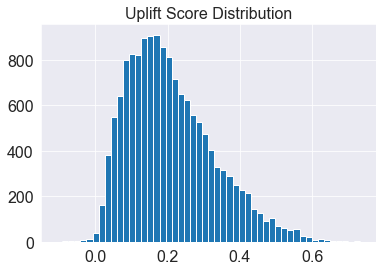

In [28]:
pipe_train_df["uplift"].hist(bins=50);
plt.title("Uplift Score Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

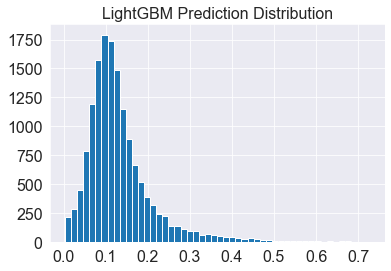

In [29]:
pipe_train_df["treatment_em1__prediction_on_control"].hist(bins=50);
plt.title("LightGBM Prediction Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

**Checking Gain Curve with ECDF**

In [30]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "prediction_ecdf"
)

In [31]:
pipeline_train_df = pipe_fcn(train_data)
pipeline_test_df = pipe_fcn(test_data)

In [32]:
gain_curve_train = gain_curve(pipeline_train_df)
gain_curve_test = gain_curve(pipeline_test_df)

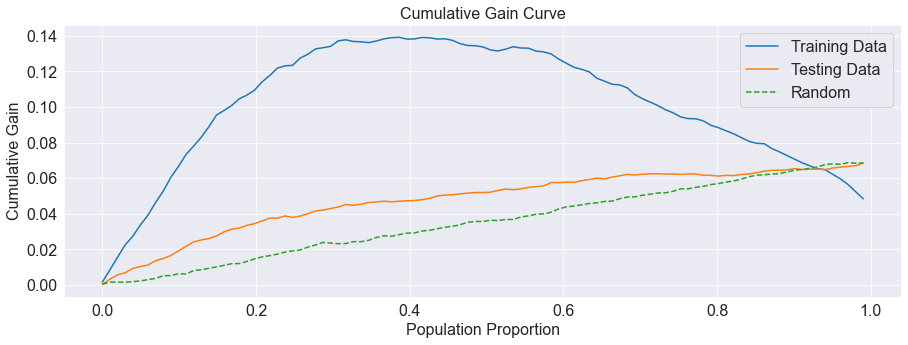

In [33]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)

#### 4.3 Build S-learner Using Lightgbm with Isotonic Calibration

In [34]:
clf_learner = lgbm_classification_learner(
    features = features,
    target = target_column,
    prediction_column = prediction_column
)

In [35]:
calibrator = isotonic_calibration_learner(
    target_column=target_column,
    prediction_column=prediction_column,
    output_column="calibration_prediction"
)

In [36]:
s_learner = causal_s_classification_learner(
    treatment_col=treatment_column,
    control_name=control_name,
    prediction_column="calibration_prediction",
    learner=clf_learner,
    learner_transformers=[calibrator]
)

In [37]:
cdf = ecdfer(
    prediction_column=score_of_interest
)

In [38]:
pipeline = build_pipeline(
    *[s_learner, cdf]
)

In [39]:
pipe_fcn, pipe_train_df, pipe_log = pipeline(
    train_data
)

[LightGBM] [Info] Number of positive: 1896, number of negative: 8896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 10792, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175686 -> initscore=-1.545855
[LightGBM] [Info] Start training from score -1.545855
[LightGBM] [Info] Number of positive: 1306, number of negative: 6376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 986
[LightGBM] [Info] Number of data points in the train set: 7682, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170008 -> initscore=-1.585572
[Ligh

In [40]:
pipe_train_df.head()

,age,income,insurance,invested,em1,em2,em3,converted,control,treatment_col,...,treatment_em3__uplift,treatment_em1__calibration_prediction_on_treatment,treatment_em1__calibration_prediction_on_control,treatment_em1__uplift,treatment_em2__calibration_prediction_on_treatment,treatment_em2__calibration_prediction_on_control,treatment_em2__uplift,uplift,suggested_treatment,prediction_ecdf
0,44.1,5483.80,6155.29,14294.81,0,0,1,0,0,em3,...,0.183083,0.793478,0.110734,0.682744,0.422222,0.293173,0.129050,0.682744,treatment_em1,882.400000
1,39.8,2737.92,50069.40,7468.15,1,0,0,0,0,em1,...,0.042952,0.028286,0.007605,0.020682,0.027972,0.027972,0.000000,0.042952,treatment_em3,116.000000
2,49.0,2712.51,5707.08,5095.65,0,0,1,1,0,em3,...,0.391279,0.969697,0.155235,0.814462,0.055556,0.000000,0.055556,0.814462,treatment_em1,963.866667
3,39.7,2326.37,15657.97,6345.20,0,0,0,0,1,control,...,0.055617,0.110734,0.006173,0.104562,0.055556,0.000000,0.055556,0.104562,treatment_em1,313.066667
4,35.3,2787.26,27074.44,14114.86,1,1,0,0,0,em1,...,0.000000,0.062081,0.000000,0.062081,0.000000,0.000000,0.000000,0.062081,treatment_em1,223.000000


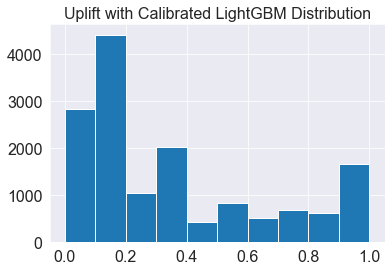

In [41]:
pipe_train_df["treatment_em1__calibration_prediction_on_treatment"].hist(bins=10);
plt.title("Uplift with Calibrated LightGBM Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

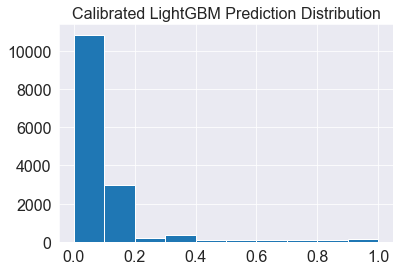

In [42]:
pipe_train_df["treatment_em1__calibration_prediction_on_control"].hist(bins=10);
plt.title("Calibrated LightGBM Prediction Distribution", fontsize=16);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

**Checking Gain Curve with ECDF**

In [44]:
gain_curve = cumulative_gain_curve(
    treatment = "em1",
    outcome = target_column,
    prediction = "prediction_ecdf"
)

In [45]:
pipeline_train_df = pipe_fcn(train_data)
pipeline_test_df = pipe_fcn(test_data)

In [46]:
gain_curve_train = gain_curve(pipeline_train_df)
gain_curve_test = gain_curve(pipeline_test_df)

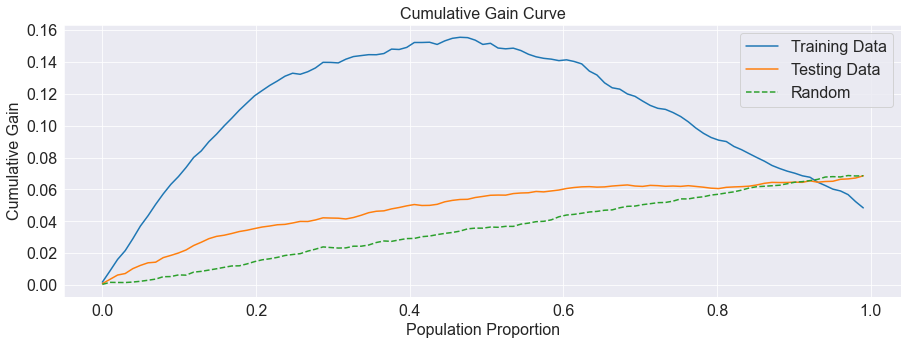

In [47]:
plot_cumulative_gain_curve(
    train_gain = gain_curve_train,
    test_gain = gain_curve_test,
    random_gain = gain_curve_random
)